Integrantes del grupo 5: 

JUAN CARLOS RODRIGUEZ RAMIREZ

JORGE GASCÓN MORENO

EDUARDO MUÑOZ LORENZO



# Mini Proyecto 1

## Aprendizaje Automático Intermedio e Ingeniería de Características

### Febrero 2021

**Emilio Parrado Hernández, Vanessa Gómez Verdejo, Pablo Martínez Olmos**

Departamento de Teoría de la Señal y Comunicaciones

**Universidad Carlos III de Madrid**

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

# Carga de datos y comprensión de las variables

In [ ]:
data_sheet = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls'
import pandas as pd
pd.set_option('display.max_columns', None)

df = pd.read_excel(data_sheet,
                  header=1,
                  skiprows=0,
                  index_col=0)

In [ ]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Descripción de las variables de entrada

Esta es la descripción extraída de la web de la que se descargan los datos

- This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. 
- This study reviewed the literature and used the following 23 variables as explanatory variables:
    - X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
    - X2: Gender (1 = male; 2 = female).
    - X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
    - X4: Marital status (1 = married; 2 = single; 3 = others).
    - X5: Age (year).
    - X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -2=no consumption, -1=pay duly, 0=the use of revolving credit, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above
    - X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
    - X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.



In [ ]:
# imprimir un registro para ver en detalle cada campo
df.loc[1568]

LIMIT_BAL                     120000
SEX                                2
EDUCATION                          2
MARRIAGE                           2
AGE                               23
PAY_0                              0
PAY_2                              0
PAY_3                              0
PAY_4                              0
PAY_5                              0
PAY_6                              0
BILL_AMT1                     118063
BILL_AMT2                     120851
BILL_AMT3                     120013
BILL_AMT4                      77539
BILL_AMT5                      77333
BILL_AMT6                      79113
PAY_AMT1                        4700
PAY_AMT2                        3538
PAY_AMT3                        3000
PAY_AMT4                        3000
PAY_AMT5                        3000
PAY_AMT6                        5000
default payment next month         0
Name: 1568, dtype: int64

## Limpieza de variables

Algunas de las variables categóricas presentan valores que no aparecen en la descripción

### Education y Marriage

In [ ]:
columns_cat = ['EDUCATION','MARRIAGE']
for cc in columns_cat:
    print(cc)
    print(df[cc].value_counts())
    print("")

EDUCATION
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

MARRIAGE
2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64



Vemos que aparecen valores que no están en la descripción, vamos a *limpiar* estas variables agrupando del siguiente modo:
- `EDUCATION`: pasar los valores $\{0, 5, 6\}$ a $4$ (`others`)
- `MARRIAGE`: pasar el valor $0$ a $3$ (`others`)

In [ ]:
df.loc[:,'EDUCATION'] = df.loc[:,'EDUCATION'].apply(lambda x: 4 if x==0 else x)
df.loc[:,'EDUCATION'] = df.loc[:,'EDUCATION'].apply(lambda x: 4 if x>=4 else x)
df.loc[:,'MARRIAGE'] = df.loc[:,'MARRIAGE'].apply(lambda x: 3 if x==0 else x)
for cc in columns_cat:
    print(cc)
    print(df[cc].value_counts())
    print("")

EDUCATION
2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

MARRIAGE
2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64



### Sacar discretas de PAY_0 a PAY_6 (3%)

Las variables `PAY_0` a `PAY_6` tienen una interpretación mixta entre categórica y numérica. Los valores $\{-2, -1 ,0\}$ pueden considerarse categóricos, mientras que los valores positivos pueden considerarse numéricos.

Vamos a codificarlas de modo categórico con las siguientes categorías:
- `PAY_X` $=-2$: no consumption
- `PAY_X` $=-1$: pay duly  
- `PAY_X` $=0$:  use of revolving credit
- `PAY_X` $ >0$: payment delay

Básicamente tenéis que escribir código que:
 - transforme todos los valores positivos en un solo valor, por ejemplo $1$
 - añanda columnas `PAY_X_dis` al dataframe con esos valores discretos

In [ ]:
#############
# YOUR CODE #
#############
for i in df.columns[5:11]:
    df[i+'_dis'] = df[i].apply(lambda x: 1 if x>0 else x)
#######
# END #
#######    

In [ ]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,PAY_0_dis,PAY_2_dis,PAY_3_dis,PAY_4_dis,PAY_5_dis,PAY_6_dis
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1,1,-1,-1,-2,-2
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,-1,1,0,0,0,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0,0,0,0,0,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0,0,0,0,0,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,-1,0,-1,0,0,0


## Partición en entrenamiento y test (2%)

Divida los datos aleatoriamente en dos dataframes con la siguiente distribución de tamaños:
- `train_df`: Entrenamiento 20K
- `test_df`: Test 10K

In [ ]:
df.shape

(30000, 30)

In [ ]:
#############
# YOUR CODE #
#############
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=10000, random_state=42)
#######
# END #
####### 

In [ ]:
print("Train {0:d} ejemplos".format(len(train_df)))
print("Test {0:d} ejemplos".format(len(test_df)))

Train 20000 ejemplos
Test 10000 ejemplos


## Clasificación trivial (5%)

El primer paso es establecer el clasificador *baseline* contra el que vamos a comparar los resultados de los modelos que vayamos entrenando a lo largo del *notebook*.

Este resultado depende de si las clases están o no desbalanceadas. **Analizad el desbalanceo en el dataframe** `train_df` y elegid el resultado del clasificador *baseline*.

In [ ]:
#############
# YOUR CODE #
#############
max_prob_category = train_df['default payment next month'].value_counts(normalize=True, ascending=False)
print('Si Clasificador Baseline consiste en predecir que nunca habrá impago (0), Acertaré el %s de las veces'%(train_df['default payment next month'].value_counts(normalize=True)[0]*100))
global_results ={} # to store the results of the different models for comparison purposes
global_results['Baseline'] = train_df['default payment next month'].value_counts(normalize=True)[0]
#######
# END #
####### 

Si Clasificador Baseline consiste en predecir que nunca habrá impago (0), Acertaré el 77.73 de las veces


# 1. Regresión Logística con variables numéricas

El primer modelo que vamos a construir es un clasificador basado en [**regresión logística**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) sólo empleando como entradas las variables numéricas. 

## 1.1 Identificar variables numéricas (5%)
Construid una lista de python llamada `num_var` con las variables numéricas (las que no son categóricas)

In [ ]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,PAY_0_dis,PAY_2_dis,PAY_3_dis,PAY_4_dis,PAY_5_dis,PAY_6_dis
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1,1,-1,-1,-2,-2
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,-1,1,0,0,0,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0,0,0,0,0,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0,0,0,0,0,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,-1,0,-1,0,0,0


In [ ]:
#############
# YOUR CODE #
#############
import re
r = re.compile("^PAY_[0-9]|^SEX$|^EDUCATION$|^MARRIAGE$|^defa*") # REGEX EXPRESSION
num_var = [col for col in df.columns if  col not in list(filter(r.match, df.columns))]
#######
# END #
####### 
print("Variables numéricas")
print(num_var)

Variables numéricas
['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


## 1.2 Construir el modelo de regresión logística solo con las variables numéricas (10%)

- Usad `Pipeline` y `GridSearchCV` para introducir un escalado como preprocesado, si lo veis oportuno.
- Usad los siguientes nombres para los numpy arrays con los que llaméis los métodos (`fit`, `sore`, `predict`,etc) del regresor logístico:
    - `X_train`
    - `Y_train`
    - `X_test`
    - `Y_test`
- Comparad el resultado del modelo en el conjunto de test con la solución trivial


In [ ]:
#############
# YOUR CODE #
#############
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Training set observations
X_train = train_df[num_var]
# Training set targets
Y_train = train_df['default payment next month'].values
# Test set observations
X_test = test_df[num_var]
# Test set targets
Y_test = test_df['default payment next month'].values

# Set the Pipeline
pipe = Pipeline(steps=[('scaler', MinMaxScaler()), ('logistic',LogisticRegression())])
# Params
params_pipe = {'logistic__solver':['lbfgs'],
               'logistic__max_iter':[10000],
               'logistic__penalty' : ['l2'],
               'scaler':[MinMaxScaler(), StandardScaler(),'passthrough']}
# GridSearch
grid_pipe = GridSearchCV(pipe, param_grid= params_pipe, cv=5)
grid_pipe.fit(X_train, Y_train)
print(grid_pipe.best_params_,'\n','_'*100)
print("Score with the training data {0:.4f}".format(grid_pipe.score(X_train, Y_train)))
print("Score with the test data {0:.4f}".format(grid_pipe.score(X_test,Y_test)))
# Storing the result
global_results['LogisticRegression'] = grid_pipe.score(X_test,Y_test)

# Compare performance
print("Baseline: ", global_results['Baseline'])
print("Logistic Regression: ", global_results['LogisticRegression'])
cadena = "Mejora de: {0:.4f} ({1:2f} %)".format(global_results['LogisticRegression']-global_results['Baseline'],
                                                ((global_results['LogisticRegression']/global_results['Baseline'])-1)*100) 
print(cadena)
#######
# END #
#######

{'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs', 'scaler': MinMaxScaler(copy=True, feature_range=(0, 1))} 
 ____________________________________________________________________________________________________
Score with the training data 0.7773
Score with the test data 0.7818
Baseline:  0.7773
Logistic Regression:  0.7818
Mejora de: 0.0045 (0.578927 %)


## 1.3 Pintar pesos y dar interpretación (5%)

Imprimid los pesos del regresor logístico con el nombre de la variable correspondiente

- Peso w0: XXX.XX
- peso Variable1: YYY.YY
- ...
- peso VariableM: ZZZZ.ZZZZ

y comentad la relevancia de cada variable en la clasificación. Puede ser de ayuda imprimir los pesos ordenados por valor absoluto.

In [ ]:
#############
# YOUR CODE #
#############
# Definimos una función para devolver los coeficientes de las variables del modelo y el Intercept (w0).
def getWeights(model, columns):
  weights = []
  weights_abs = []

  for var,coef in zip(columns ,model.coef_[0]):
      weights_abs.append((var,abs(coef)))
      weights.append((var,coef))
      weights_abs.sort(key=lambda tup: tup[1],reverse=True) 
  # JC: Añado el Intercept según el comentario de la tarea
  weights_abs.append(('Intercept',abs(model.intercept_[0])))  
  return weights_abs

display(getWeights(grid_pipe.best_estimator_.named_steps['logistic'], num_var))

#######
# END #
#######

[('PAY_AMT1', 3.8501254220015264),
 ('LIMIT_BAL', 3.3265242636644956),
 ('PAY_AMT2', 2.7963163201301877),
 ('PAY_AMT3', 2.725691935972648),
 ('PAY_AMT4', 2.3312367273427923),
 ('PAY_AMT5', 1.9948912830676688),
 ('BILL_AMT6', 1.7333532831751477),
 ('PAY_AMT6', 1.6079067358231844),
 ('BILL_AMT5', 1.320177327116607),
 ('BILL_AMT1', 1.262533971538699),
 ('BILL_AMT2', 0.5893074236962219),
 ('AGE', 0.49490522856348046),
 ('BILL_AMT4', 0.473303124296246),
 ('BILL_AMT3', 0.02480793546585379),
 ('Intercept', 1.2557057973160866)]

El Amount bill statement y la cantidad de crédito concedido son las variables que más influyen en el modelo

## 1.4 Curva ROC (10%)

Dibujar la [curva ROC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) del clasificador anterior y calcular el [área bajo la curva](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html). Usad el conjunto de test para este apartado.

AUC is the percentage of the ROC plot that is underneath the curve: 0.6345771843350054


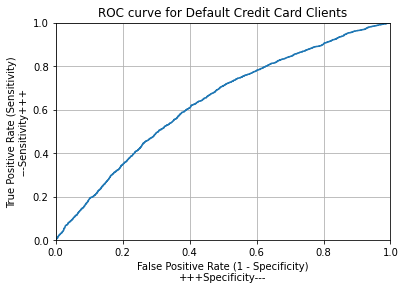

In [ ]:
#############
# YOUR CODE #
#############
from sklearn import metrics
import matplotlib.pyplot as plt

def roc(x_test, y_test, classifier):
    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    y_pred_prob = classifier.predict_proba(x_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC curve for Default Credit Card Clients')
    plt.xlabel('False Positive Rate (1 - Specificity)\n+++Specificity---')
    plt.ylabel('True Positive Rate (Sensitivity)\n---Sensitivity+++')
    plt.grid(True)
    print('AUC is the percentage of the ROC plot that is underneath the curve:',metrics.roc_auc_score(y_test, y_pred_prob))
roc(X_test, Y_test, grid_pipe)
#######
# END #
#######

## 1.5 Transformación logarítmica de las variables numéricas y comparar (5%)

Para controlar el impacto de los rangos de las variables numéricas vamos a emplear una transformación logarítmica. Como hay valores que pueden ser negativos, y el logaritmo sólo está definido para valores positivos, vamos a extender la transformación de modo que:
$$
y(x) = \mbox{signo}(x) \log_{10}(x)
$$

Escriba código que:
- Aplique la siguiente función para hacer la transformación de los numpy arrays `X_train` y `X_test` en `LXtrain` y `LXtest`.
- Entrene un modelo de regresión logística con las variables transformadas
- Compare el acierto de este modelo con el baseline y con el modelo anterior
- Pinte la curva ROC de este modelo y calcule el área bajo la curva
- Imprima los valores de los pesos del modelo correspondiente a cada variable 

Discuta las diferencias entre este modelo y el anterior

In [ ]:
import numpy as np
def log_transform(x):
    negativos = x <0
    ceros = x == 0
    ax = np.absolute(x)
    ax[ceros] = 1
    Lx = np.log10(ax)
    Lx[negativos] = -Lx[negativos]
    Lx[ceros] = 0
    return Lx

In [ ]:
# Definimos esta función para mostrar un pequeño reporte del modelo entrenado
def printReport(grid_pipe, Xtrain, Ytrain, Xtest, Ytest, global_results, modelo = 'logistic', column_names=None, show_weights=True):
  print(grid_pipe.best_params_,'\n','_'*100)
  print("Score with the training data {0:.4f}".format(grid_pipe.score(Xtrain, Ytrain)))
  print("Score with the test data {0:.4f}".format(grid_pipe.score(Xtest,Ytest)),'\n','_'*100)
  print(global_results,'\n','_'*100)
  ax = pd.DataFrame(global_results.items(),columns=['modelo', 'accuracy']).plot(kind="bar", figsize=(12,5), ylim=(0.65,0.9)).set_xticklabels(global_results.keys(), rotation=45, ha='right')
  plt.show()  
  print('\n','_'*100)

  if column_names is None:
    column_names = Xtrain.columns
  # ROC AUC
  roc(Xtest, Ytest, grid_pipe)
  plt.show()
  if show_weights:
    # Weights
    weights_abs = getWeights(grid_pipe.best_estimator_.named_steps[modelo],column_names)

    print('_'*101,'\n''Variable que más peso tiene (valor absoluto)',weights_abs[0])
    print('2º Variable que más peso tiene (valor absoluto)',weights_abs[1])
    print('3º Variable que más peso tiene (valor absoluto)',weights_abs[2])
    print('_'*101)
    display(weights_abs)

{'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs', 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)} 
 ____________________________________________________________________________________________________
Score with the training data 0.7876
Score with the test data 0.7876 
 ____________________________________________________________________________________________________
{'Baseline': 0.7773, 'LogisticRegression': 0.7818, 'LOG_LogisticRegression': 0.7876} 
 ____________________________________________________________________________________________________


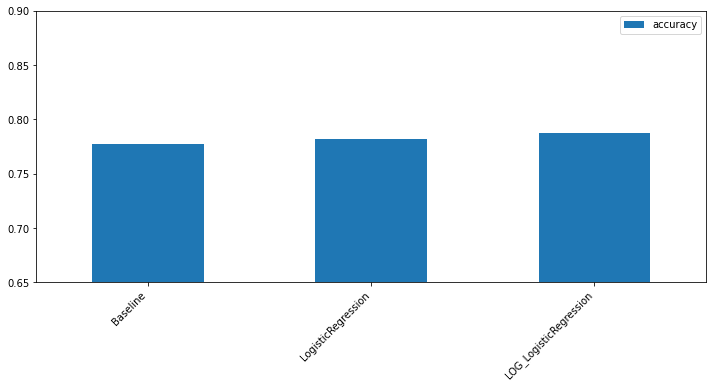


 ____________________________________________________________________________________________________
AUC is the percentage of the ROC plot that is underneath the curve: 0.707847310690341


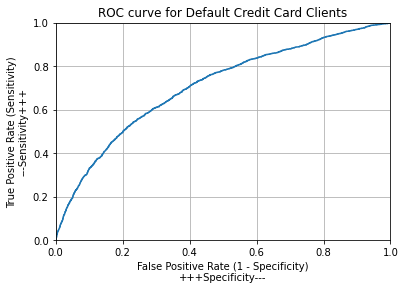

_____________________________________________________________________________________________________ 
Variable que más peso tiene (valor absoluto) ('PAY_AMT1', 0.41732795080992646)
2º Variable que más peso tiene (valor absoluto) ('PAY_AMT2', 0.41035606137684993)
3º Variable que más peso tiene (valor absoluto) ('BILL_AMT3', 0.3687363237096042)
_____________________________________________________________________________________________________


[('PAY_AMT1', 0.41732795080992646),
 ('PAY_AMT2', 0.41035606137684993),
 ('BILL_AMT3', 0.3687363237096042),
 ('BILL_AMT6', 0.3077056877142738),
 ('PAY_AMT3', 0.3006273613723214),
 ('BILL_AMT2', 0.24194059799315634),
 ('LIMIT_BAL', 0.2243831295896373),
 ('BILL_AMT4', 0.21140540113836098),
 ('PAY_AMT5', 0.2017051496429851),
 ('PAY_AMT4', 0.19565279196780586),
 ('BILL_AMT1', 0.12746010244072184),
 ('AGE', 0.08560280715222313),
 ('PAY_AMT6', 0.08107298108266536),
 ('BILL_AMT5', 0.04997619265974592),
 ('Intercept', 1.4042980894850836)]

In [ ]:
#############
# YOUR CODE #
#############

# Log Transformation
LXtrain = X_train.apply(log_transform)
LXtest = X_test.apply(log_transform)

# GridSearch
grid_pipe = GridSearchCV(pipe, param_grid= params_pipe, cv=5)
grid_pipe.fit(LXtrain, Y_train)
# Storing the result
global_results['LOG_LogisticRegression'] = grid_pipe.score(LXtest,Y_test)

# Print result
printReport(grid_pipe, LXtrain, Y_train, LXtest, Y_test, global_results)
#######
# END #
#######




## 1.6 Combinaciones de variables numéricas, extensión polinómica y de ratios (5%)

Para completar el análisis de las variables numéricas vamos a extender las mismas con combinaciones de variables. 

Escriba código que:
- Extienda las variables en los arrays `LXtrain` y `LXtest` a combinaciones de grado 2, y con variables sin repetir (es decir, con el argumento `interaction_only=True`).
- Entrena un modelo de clasificación con regresión logística con las características resultantes
- Compare el acierto de este modelo con el baseline y con los modelos anteriores
- Pinte la curva ROC de este modelo y calcule el área bajo la curva
- Imprima los valores de los pesos del modelo correspondiente a cada variable 

Discuta las diferencias entre este modelo y los anteriores

{'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs', 'scaler': MinMaxScaler(copy=True, feature_range=(0, 1))} 
 ____________________________________________________________________________________________________
Score with the training data 0.7903
Score with the test data 0.7886 
 ____________________________________________________________________________________________________
{'Baseline': 0.7773, 'LogisticRegression': 0.7818, 'LOG_LogisticRegression': 0.7876, 'POL_2_LOG_LogisticRegression': 0.7886} 
 ____________________________________________________________________________________________________


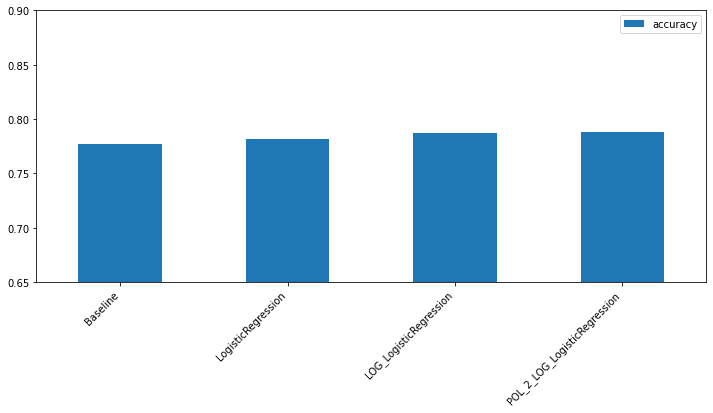


 ____________________________________________________________________________________________________
AUC is the percentage of the ROC plot that is underneath the curve: 0.7141352396254008


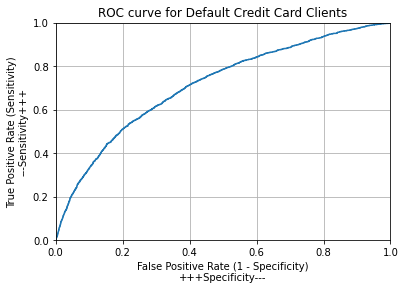

_____________________________________________________________________________________________________ 
Variable que más peso tiene (valor absoluto) ('BILL_AMT3 PAY_AMT2', 2.084497619000569)
2º Variable que más peso tiene (valor absoluto) ('BILL_AMT2 PAY_AMT1', 1.6297678097312995)
3º Variable que más peso tiene (valor absoluto) ('BILL_AMT2', 1.6198803425225676)
_____________________________________________________________________________________________________


[('BILL_AMT3 PAY_AMT2', 2.084497619000569),
 ('BILL_AMT2 PAY_AMT1', 1.6297678097312995),
 ('BILL_AMT2', 1.6198803425225676),
 ('LIMIT_BAL PAY_AMT1', 1.3669356025775834),
 ('BILL_AMT3 PAY_AMT1', 1.3080497958382222),
 ('BILL_AMT2 PAY_AMT2', 1.122902191929759),
 ('AGE BILL_AMT1', 1.1047921678065826),
 ('BILL_AMT3 BILL_AMT4', 1.0960938171658925),
 ('BILL_AMT2 PAY_AMT6', 1.0813175102823902),
 ('BILL_AMT4 PAY_AMT3', 1.0654058518543568),
 ('PAY_AMT1 PAY_AMT3', 1.047746575260465),
 ('BILL_AMT3 BILL_AMT5', 0.9561246722434615),
 ('LIMIT_BAL', 0.9294263222713197),
 ('BILL_AMT2 PAY_AMT5', 0.9203516345093841),
 ('LIMIT_BAL PAY_AMT6', 0.9183310270510567),
 ('PAY_AMT3 PAY_AMT4', 0.911395440455102),
 ('BILL_AMT1 BILL_AMT2', 0.7835025894767492),
 ('BILL_AMT2 PAY_AMT3', 0.7584875891889986),
 ('BILL_AMT4 BILL_AMT6', 0.7523902587517061),
 ('BILL_AMT6 PAY_AMT1', 0.7409858512208554),
 ('PAY_AMT4 PAY_AMT5', 0.7395538369999803),
 ('PAY_AMT2 PAY_AMT3', 0.7358012254681868),
 ('LIMIT_BAL BILL_AMT1', 0.6747702088

In [ ]:
#############
# YOUR CODE #
#############
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(interaction_only=True, 
                          degree=2,
                          include_bias=False)
LXtrain_e = poly.fit_transform(LXtrain)
LXtest_e = poly.transform(LXtest)

# GridSearch
grid_pipe = GridSearchCV(pipe, param_grid= params_pipe, cv=5)
grid_pipe.fit(LXtrain_e, Y_train)

# Storing the result
global_results['POL_2_LOG_LogisticRegression'] = grid_pipe.score(LXtest_e,Y_test)

# Print result
printReport(grid_pipe, LXtrain_e, Y_train, LXtest_e, Y_test, global_results, 'logistic', poly.get_feature_names(LXtrain.columns))

#######
# END #
#######

# 2. Añadir variables categóricas con dummy encodings 

En la siguiente sección vamos a enriquecer los modelos añadiendo variables categóricas



## 2.1 Discretizar edad en 5 bins (10%)

Vamos a comenzar discretizando la edad en 5 *bins*. Escriba código que
- Discretice la variable `AGE` en 5 *bins* con aproximadamente el mismo número de clientes en cada bin, incluyendo una columna llamada 'AGE_bins' en los dataframes `train_df` y `test_df` con los números de *bin* correspondiente
- Obtenga numpy arrays `X_train_cat_dummy` y `X_test_cat_dummy` con la codificación *dummy* de las variable `AGE_bins`
- Extienda las observaciones añadiendo estos arrays a `LXtrain` y `LXtest` (no incluyáis las extensiones polinómicas). Eliminando la columna correspondiente a la variable `AGE`original.
- Entrene un modelo de clasificación con regresión logística con las características resultantes
- Compare el acierto de este modelo con el baseline y con los modelos anteriores
- Pinte la curva ROC de este modelo y calcule el área bajo la curva
- Imprima los valores de los pesos del modelo correspondiente a cada variable 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


{'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs', 'scaler': 'passthrough'} 
 ____________________________________________________________________________________________________
Score with the training data 0.7879
Score with the test data 0.7886 
 ____________________________________________________________________________________________________
{'Baseline': 0.7773, 'LogisticRegression': 0.7818, 'LOG_LogisticRegression': 0.7876, 'POL_2_LOG_LogisticRegression': 0.7886, 'AGE_dummies_LOG_LogisticRegression': 0.7886} 
 ____________________________________________________________________________________________________


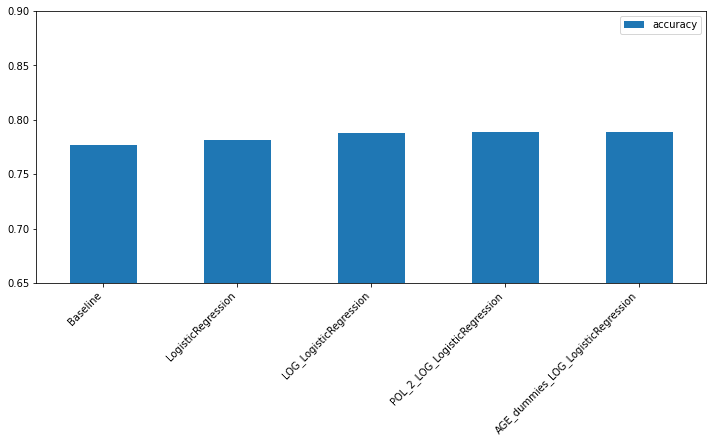


 ____________________________________________________________________________________________________
AUC is the percentage of the ROC plot that is underneath the curve: 0.7070420407534471


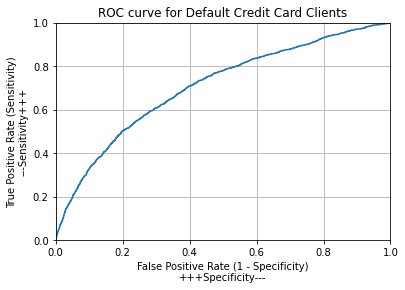

_____________________________________________________________________________________________________ 
Variable que más peso tiene (valor absoluto) ('LIMIT_BAL', 0.5550114714595584)
2º Variable que más peso tiene (valor absoluto) ('PAY_AMT1', 0.2957862584114888)
3º Variable que más peso tiene (valor absoluto) ('PAY_AMT2', 0.2898392677753938)
_____________________________________________________________________________________________________


[('LIMIT_BAL', 0.5550114714595584),
 ('PAY_AMT1', 0.2957862584114888),
 ('PAY_AMT2', 0.2898392677753938),
 ('AGE_bin_3', 0.24549090210882565),
 ('BILL_AMT3', 0.21949342442799416),
 ('AGE_bin_4', 0.2158544524403129),
 ('PAY_AMT3', 0.2062558913815567),
 ('BILL_AMT6', 0.16919434031474592),
 ('BILL_AMT2', 0.14809849975443287),
 ('PAY_AMT5', 0.13479196632555399),
 ('PAY_AMT4', 0.1325272194071846),
 ('BILL_AMT4', 0.12208098245383155),
 ('AGE_bin_2', 0.10671213650044727),
 ('BILL_AMT1', 0.08301626302427415),
 ('AGE_bin_1', 0.05989319164667207),
 ('PAY_AMT6', 0.05286216128797591),
 ('BILL_AMT5', 0.028128556065830132),
 ('Intercept', 2.1505394921197887)]

In [ ]:
#############
# YOUR CODE #
#############
from sklearn.preprocessing import OneHotEncoder

# BINS
bins = train_df['AGE'].quantile([.2,.4,.6,.8])
train_df['AGE_bins'] = np.digitize(train_df['AGE'].values, bins)
test_df['AGE_bins'] = np.digitize(test_df['AGE'].values, bins)

# Dummy Coding
dummy = OneHotEncoder(sparse = False,drop='first')
X_train_cat_dummy = dummy.fit_transform(train_df[['AGE_bins']])
X_test_cat_dummy = dummy.transform(test_df[['AGE_bins']])
for i in dummy.categories_[0][1:]:
    LXtrain['AGE_bin_'+str(i)] = X_train_cat_dummy[:,i-1]
    LXtest['AGE_bin_'+str(i)] = X_test_cat_dummy[:,i-1]

# FINAL X_Train X_test
LXtrain.drop(columns=['AGE'],inplace=True)
LXtest.drop(columns=['AGE'],inplace=True)

# GridSearch
grid_pipe = GridSearchCV(pipe, param_grid= params_pipe, cv=5)
grid_pipe.fit(LXtrain, Y_train)

# Storing the result
global_results['AGE_dummies_LOG_LogisticRegression'] = grid_pipe.score(LXtest,Y_test)

# Print result
printReport(grid_pipe, LXtrain, Y_train, LXtest, Y_test, global_results)
#######
# END #
#######

## 2.2 Añadir más variables categóricas: variables PAY_0 a PAY_6 e info sociodemográfica (10%)

A continuación  vamos a añadir al modelo las variables que describen el histórico de los usos del crédito y de los retrasos en el pago y las variables `SEX`,`EDUCATION`, `MARRIAGE` y `AGE_bins` codificadas con *dummy encoding*.
. Escriba código que: 
- Obtenga numpy arrays `X_train_cat_dummy` y `X_test_cat_dummy` con la codificación *dummy* de las variables `SEX`,`EDUCATION`,`MARRIAGE`, `PAY_0_dis`, `PAY_2_dis`, `PAY_3_dis`, `PAY_4_dis`, `PAY_5_dis` y `PAY_6_dis`
- Extienda las observaciones añadiendo estos arrays a `LXtrain` y `LXtest` (no incluyáis las extensiones polinómicas). Eliminando la columna correspondiente a la variable `AGE`original.
- Entrene un modelo de clasificación con regresión logística con las características resultantes
- Compare el acierto de este modelo con el baseline y con los modelos anteriores
- Pinte la curva ROC de este modelo y calcule el área bajo la curva
- Imprima los valores de los pesos del modelo correspondiente a cada variable 


{'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs', 'scaler': MinMaxScaler(copy=True, feature_range=(0, 1))} 
 ____________________________________________________________________________________________________
Score with the training data 0.8135
Score with the test data 0.8110 
 ____________________________________________________________________________________________________
{'Baseline': 0.7773, 'LogisticRegression': 0.7818, 'LOG_LogisticRegression': 0.7876, 'POL_2_LOG_LogisticRegression': 0.7886, 'AGE_dummies_LOG_LogisticRegression': 0.7886, 'More_CAT_dummies_LOG_LogisticRegression': 0.811} 
 ____________________________________________________________________________________________________


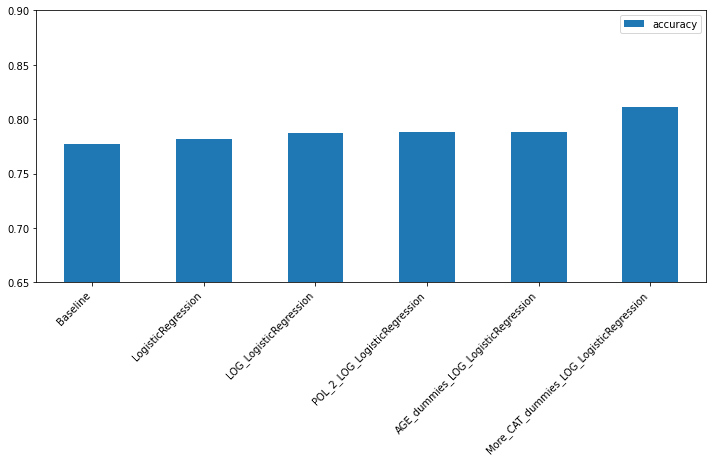


 ____________________________________________________________________________________________________
AUC is the percentage of the ROC plot that is underneath the curve: 0.7637216543458081


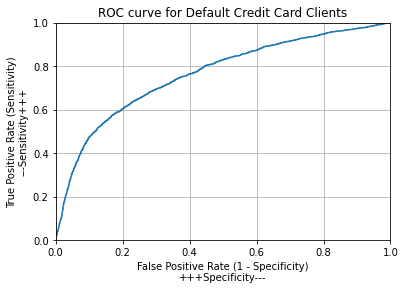

_____________________________________________________________________________________________________ 
Variable que más peso tiene (valor absoluto) ('PAY_0_dis1', 1.3824814147052797)
2º Variable que más peso tiene (valor absoluto) ('LIMIT_BAL', 0.9898727129617191)
3º Variable que más peso tiene (valor absoluto) ('PAY_2_dis1', 0.9214967399468533)
_____________________________________________________________________________________________________


[('PAY_0_dis1', 1.3824814147052797),
 ('LIMIT_BAL', 0.9898727129617191),
 ('PAY_2_dis1', 0.9214967399468533),
 ('EDUCATION2', 0.8353307143048778),
 ('BILL_AMT3', 0.7399471948790406),
 ('PAY_AMT2', 0.7179442336848001),
 ('BILL_AMT2', 0.6988783244157338),
 ('BILL_AMT1', 0.6662835247512309),
 ('PAY_0_dis2', 0.6319904774808187),
 ('PAY_AMT3', 0.5983568727016184),
 ('PAY_3_dis2', 0.5307342911968781),
 ('BILL_AMT5', 0.48836032894084375),
 ('BILL_AMT6', 0.41653922016367334),
 ('PAY_2_dis2', 0.40651590782272756),
 ('PAY_5_dis2', 0.39161419945043097),
 ('PAY_6_dis2', 0.37175108509102206),
 ('BILL_AMT4', 0.3310585766348298),
 ('PAY_3_dis1', 0.28477535625331785),
 ('PAY_0_dis0', 0.2719573556451583),
 ('PAY_AMT1', 0.268090443180465),
 ('PAY_AMT4', 0.2580150881615054),
 ('PAY_4_dis2', 0.22567079021523104),
 ('MARRIAGE1', 0.218745094088017),
 ('PAY_2_dis0', 0.20591136635819582),
 ('PAY_5_dis1', 0.18451287312454923),
 ('MARRIAGE0', 0.15272449536950744),
 ('PAY_AMT5', 0.14452561374703324),
 ('AGE_bin_

In [ ]:
#############
# YOUR CODE #
#############
# Dummy Coding

def create_dummy(var,train,test,x_train,x_test):
    dummy = OneHotEncoder(sparse = False,drop='first')
    X_train_cat_dummy = dummy.fit_transform(train[[var]])
    X_test_cat_dummy = dummy.transform(test[[var]])
    for i in range(len(dummy.categories_[0][1:])):
        x_train[var+str(i)] = X_train_cat_dummy[:,i]
        x_test[var+str(i)] = X_test_cat_dummy[:,i]

cat_vars = ['SEX','EDUCATION','MARRIAGE', 'PAY_0_dis', 'PAY_2_dis', 'PAY_3_dis', 'PAY_4_dis', 'PAY_5_dis', 'PAY_6_dis']
for col in cat_vars:
    create_dummy(col,train_df,test_df,LXtrain,LXtest)

# GridSearch
grid_pipe = GridSearchCV(pipe, param_grid= params_pipe, cv=5)
grid_pipe.fit(LXtrain, Y_train)

# Storing the result
global_results['More_CAT_dummies_LOG_LogisticRegression'] = grid_pipe.score(LXtest,Y_test)

# Print result
printReport(grid_pipe, LXtrain, Y_train, LXtest, Y_test, global_results)

#######
# END #
#######

## 2.4 OPCIONAL: métodos no lineales (10%, extra)

**Este apartado es opcional: su nota se suma a la nota del proyecto, pero no es necesario para conseguir la máxima calificación.**

Podemos cambiar la tecnología de clasificación por si acaso el modelo que mejor se ajuste a nuestros datos fuese no lineal. 

Escribid código que evalúe modelos construidos con $k$ vecinos más próximos. Emplead como juegos de características los del apartado anterior. Explorad el rango de vecinos entre 1 y 101 (no hace falta que probéis todos los valores, que la base de datos no es pequeña)

Alternativamente podéis emplear [*Random Forest*](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) explorando estos rangos de parámetros:
- `n_estimators` 
- `max_leaf_nodes` o `max_depth`

{'rf__max_depth': 30, 'rf__n_estimators': 80, 'scaler': 'passthrough'} 
 ____________________________________________________________________________________________________
Score with the training data 0.9973
Score with the test data 0.8082 
 ____________________________________________________________________________________________________
{'Baseline': 0.7773, 'LogisticRegression': 0.7818, 'LOG_LogisticRegression': 0.7876, 'POL_2_LOG_LogisticRegression': 0.7886, 'AGE_dummies_LOG_LogisticRegression': 0.7886, 'More_CAT_dummies_LOG_LogisticRegression': 0.811, 'More_CAT_dummies_LOG_RandomForest': 0.8082} 
 ____________________________________________________________________________________________________


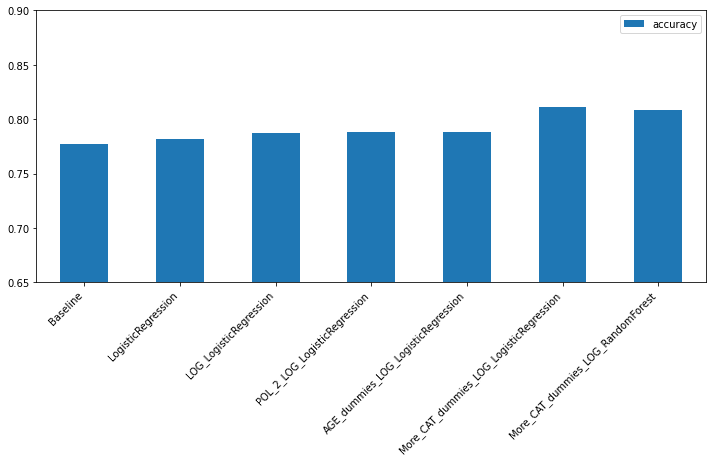


 ____________________________________________________________________________________________________
AUC is the percentage of the ROC plot that is underneath the curve: 0.7519668060193415


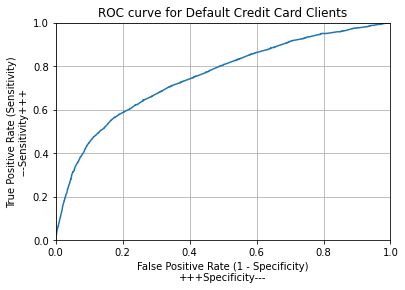

In [ ]:
#############
# YOUR CODE #
#############
from sklearn.ensemble import RandomForestClassifier

# Set the Pipeline
pipe_rf = Pipeline(steps=[('scaler', MinMaxScaler()), ('rf',RandomForestClassifier())])
# Params
params_pipe_rf = {'rf__n_estimators':[1,20,80,100],
               'rf__max_depth':[30,35,40],
               'scaler':[MinMaxScaler(), StandardScaler(),'passthrough']}
# GridSearch
grid_pipe = GridSearchCV(pipe_rf, param_grid= params_pipe_rf, cv=5)
grid_pipe.fit(LXtrain, Y_train)

# Storing the result
global_results['More_CAT_dummies_LOG_RandomForest'] = grid_pipe.score(LXtest,Y_test)

# Print result
printReport(grid_pipe, LXtrain, Y_train, LXtest, Y_test, global_results, 'rf', None, False)

#######
# END #
#######

# 3. Estudio de grupos demográficos

En la última sección vamos a intentar mejorar la interpretabilidad de los modelos mediante la creción de unas variables que segmenten los clientes atendiendo a criterios sociodemográficos.

En primer lugar vamos a definir los segmentos de clientes definidos por las variables `SEX`,`EDUCATION`,`MARRIAGE`,`AGE_bins`. Primero vamos a agrupar estas variables en una única variable categórica `GRUPO` que tomará distintos valores enteros en función de las combinaciones de estas variables.

El siguiente código es una manera de conseguir esto. Básicamente cada grupo se codifica con un entero que resulta de sumar los siquientes valores:

$$
\mbox{GRUPO}(x) = 1000 \times x[\mbox{'SEX'}] + 100 \times x[\mbox{'EDUCATION'}] + 10 \times x[\mbox{'MARRIAGE'}] + x[\mbox{'AGE_bins'}] 
$$



In [ ]:
columns_cat = ['SEX','EDUCATION','MARRIAGE','AGE_bins']
mascara = np.array([1000, 100, 10, 1])
train_df.loc[:,'GRUPO'] = (train_df.loc[:,columns_cat].values).dot(mascara)
test_df.loc[:,'GRUPO']= (test_df.loc[:,columns_cat].values).dot(mascara)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


## 3.1 Grupos con dummy encoding y variables continuas (10%)

La primera aproximación consiste en codificar *dummy encoding* la variable grupo. En este caso hay que pasarle al objeto `OneHotEncoder` un listado con las categorías que hay en cada característica porque puede que algún grupo minoritario aparezca en el conjunto de test pero no en el de entrenamiento, por lo que el codificador no va a ser capaz de aprender todos los valores de esa característica solo mirando el conjunto de entrenamiento.

El siguiente código se encarga de hacer esto mismo. La salida de este código son dos variables a tener en cuenta:
- `lista_grupo`: lista de python con todos los valores que puede tomar la variable `GRUPO`
- `dict_grupo`: diccionario de python donde cada valor que puede tomar la variable `GRUPO` se empareja con una cadena de caracteres que describe el segmento de clientes que codifica este valor



In [ ]:
lista_values = []
for cc,mm in zip(['SEX','EDUCATION','MARRIAGE','AGE_bins'], mascara):
    lista_values.append([(jj)*mm for jj in np.unique(train_df[cc].values)])
print(lista_values)
import itertools
lista_grupo = []
dict_grupo = {}
for element in itertools.product(*lista_values):
    code_grupo = np.sum(np.asarray(element))
    lista_grupo.append(code_grupo)
    dict_grupo[code_grupo] = "SEX_{0:d}_EDU_{1:d}_MAR_{2:d}_AGE_{3:d}".format(int(element[0]/1000), 
                                                                              int(element[1]/100), 
                                                                              int(element[2]/10), 
                                                                              int(element[3]))   

print("")
print("lista_grupo: ",lista_grupo)
print("")
print("dict_grupo",dict_grupo)

[[1000, 2000], [100, 200, 300, 400], [10, 20, 30], [0, 1, 2, 3, 4]]

lista_grupo:  [1110, 1111, 1112, 1113, 1114, 1120, 1121, 1122, 1123, 1124, 1130, 1131, 1132, 1133, 1134, 1210, 1211, 1212, 1213, 1214, 1220, 1221, 1222, 1223, 1224, 1230, 1231, 1232, 1233, 1234, 1310, 1311, 1312, 1313, 1314, 1320, 1321, 1322, 1323, 1324, 1330, 1331, 1332, 1333, 1334, 1410, 1411, 1412, 1413, 1414, 1420, 1421, 1422, 1423, 1424, 1430, 1431, 1432, 1433, 1434, 2110, 2111, 2112, 2113, 2114, 2120, 2121, 2122, 2123, 2124, 2130, 2131, 2132, 2133, 2134, 2210, 2211, 2212, 2213, 2214, 2220, 2221, 2222, 2223, 2224, 2230, 2231, 2232, 2233, 2234, 2310, 2311, 2312, 2313, 2314, 2320, 2321, 2322, 2323, 2324, 2330, 2331, 2332, 2333, 2334, 2410, 2411, 2412, 2413, 2414, 2420, 2421, 2422, 2423, 2424, 2430, 2431, 2432, 2433, 2434]

dict_grupo {1110: 'SEX_1_EDU_1_MAR_1_AGE_0', 1111: 'SEX_1_EDU_1_MAR_1_AGE_1', 1112: 'SEX_1_EDU_1_MAR_1_AGE_2', 1113: 'SEX_1_EDU_1_MAR_1_AGE_3', 1114: 'SEX_1_EDU_1_MAR_1_AGE_4', 1120: 'SEX_1_EDU_1

Escriba código que construya el argumento que se le debe pasar a la clase `OneHotEncoder` como argumento `categories` si queremos codificar *dummy encoding* las variables `GRUPO`, `PAY_0_dis`, `PAY_2_dis`, `PAY_3_dis`, `PAY_4_dis`, `PAY_5_dis` y `PAY_6_dis`. Este argumento debe ser un array de listas, donde cada elemento del array principal es la lista con todos los valores que debe tomar la categoría:

`lista=[[lista_grupo],[lista_PAY_0_dis],...,[lista_PAY_6_dis]]`

In [ ]:
#############
# YOUR CODE #
#############

cat_list = []
cat_columns = train_df.filter(regex='PAY_\d_dis').columns.to_list()
#cat_list = [[]]*(len(PAY_X_columns + 1))
for col in cat_columns: 
  print(col)
  print(sorted(train_df[col].unique().tolist()))
  cat_list.append(sorted(train_df[col].unique().tolist()))
cat_list.append(lista_grupo)
print(cat_list) 
cat_columns.append('GRUPO')
print(cat_columns)
len(cat_list)
#######
# END #
#######

PAY_0_dis
[-2, -1, 0, 1]
PAY_2_dis
[-2, -1, 0, 1]
PAY_3_dis
[-2, -1, 0, 1]
PAY_4_dis
[-2, -1, 0, 1]
PAY_5_dis
[-2, -1, 0, 1]
PAY_6_dis
[-2, -1, 0, 1]
[[-2, -1, 0, 1], [-2, -1, 0, 1], [-2, -1, 0, 1], [-2, -1, 0, 1], [-2, -1, 0, 1], [-2, -1, 0, 1], [1110, 1111, 1112, 1113, 1114, 1120, 1121, 1122, 1123, 1124, 1130, 1131, 1132, 1133, 1134, 1210, 1211, 1212, 1213, 1214, 1220, 1221, 1222, 1223, 1224, 1230, 1231, 1232, 1233, 1234, 1310, 1311, 1312, 1313, 1314, 1320, 1321, 1322, 1323, 1324, 1330, 1331, 1332, 1333, 1334, 1410, 1411, 1412, 1413, 1414, 1420, 1421, 1422, 1423, 1424, 1430, 1431, 1432, 1433, 1434, 2110, 2111, 2112, 2113, 2114, 2120, 2121, 2122, 2123, 2124, 2130, 2131, 2132, 2133, 2134, 2210, 2211, 2212, 2213, 2214, 2220, 2221, 2222, 2223, 2224, 2230, 2231, 2232, 2233, 2234, 2310, 2311, 2312, 2313, 2314, 2320, 2321, 2322, 2323, 2324, 2330, 2331, 2332, 2333, 2334, 2410, 2411, 2412, 2413, 2414, 2420, 2421, 2422, 2423, 2424, 2430, 2431, 2432, 2433, 2434]]
['PAY_0_dis', 'PAY_2_dis', 'PAY

7

A continuación escribid código que:
- Obtenga numpy arrays `X_train_cat_dummy` y `X_test_cat_dummy` con la codificación *dummy* de las variables `GRUPO`, `PAY_0_dis`, `PAY_2_dis`, `PAY_3_dis`, `PAY_4_dis`, `PAY_5_dis` y `PAY_6_dis`
- Extienda las observaciones añadiendo estos arrays a `LXtrain` y `LXtest` (no incluyáis las extensiones polinómicas). Eliminando la columna correspondiente a la variable `AGE` original.
- Entrene un modelo de clasificación con regresión logística con las características resultantes
- Compare el acierto de este modelo con el baseline y con los modelos anteriores
- Pinte la curva ROC de este modelo y calcule el área bajo la curva
- Imprima los valores de los pesos del modelo correspondiente a cada variable 

Index(['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')
['PAY_0_dis', 'PAY_2_dis', 'PAY_3_dis', 'PAY_4_dis', 'PAY_5_dis', 'PAY_6_dis', 'GRUPO']
Number of columns after encoding: 151
{'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs', 'scaler': MinMaxScaler(copy=True, feature_range=(0, 1))} 
 ____________________________________________________________________________________________________
Score with the training data 0.8131
Score with the test data 0.8111 
 ____________________________________________________________________________________________________
{'Baseline': 0.7773, 'LogisticRegression': 0.7818, 'LOG_LogisticRegression': 0.7876, 'POL_2_LOG_LogisticRegression': 0.7886, 'AGE_dummies_LOG_LogisticRegression': 0.7886, 'More_CAT_dummies_LOG_LogisticRegression': 0.811, 'More_CAT_dummies_LOG_

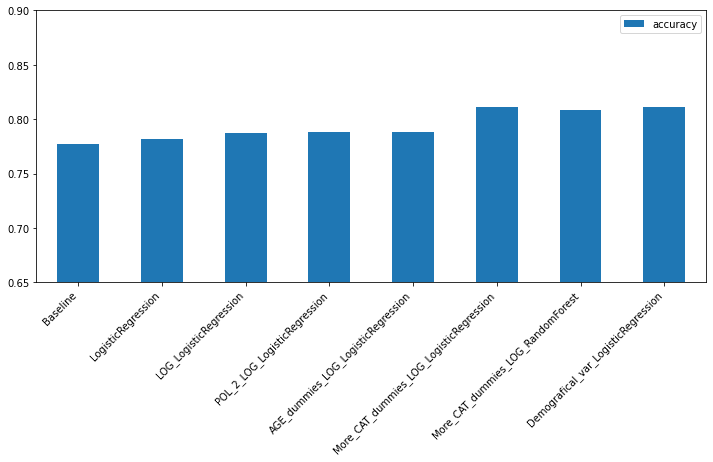


 ____________________________________________________________________________________________________
AUC is the percentage of the ROC plot that is underneath the curve: 0.7584990945476127


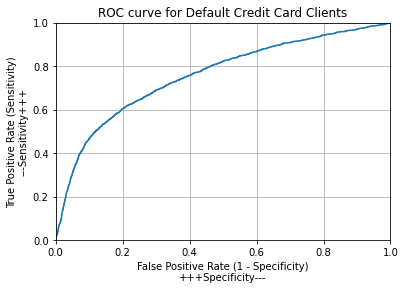

_____________________________________________________________________________________________________ 
Variable que más peso tiene (valor absoluto) ('GRUPO47', 1.2188262456542023)
2º Variable que más peso tiene (valor absoluto) ('LIMIT_BAL', 1.04846860184292)
3º Variable que más peso tiene (valor absoluto) ('GRUPO70', 1.015510810971279)
_____________________________________________________________________________________________________


[('GRUPO47', 1.2188262456542023),
 ('LIMIT_BAL', 1.04846860184292),
 ('GRUPO70', 1.015510810971279),
 ('GRUPO4', 0.9521841052765919),
 ('GRUPO31', 0.8229068704922748),
 ('GRUPO102', 0.7898752115371321),
 ('GRUPO69', 0.7641381547152992),
 ('BILL_AMT3', 0.7492930576980775),
 ('GRUPO64', 0.7310519505897544),
 ('PAY_AMT2', 0.730761956849284),
 ('BILL_AMT2', 0.6824512190501254),
 ('GRUPO49', 0.681679589590608),
 ('GRUPO32', 0.6689535802262861),
 ('BILL_AMT1', 0.6525068636664201),
 ('GRUPO91', 0.6313804645289182),
 ('GRUPO46', 0.6296607848892549),
 ('GRUPO43', 0.6101914633639414),
 ('PAY_AMT3', 0.6011240752204919),
 ('GRUPO19', 0.5759748025580989),
 ('GRUPO104', 0.563480872230395),
 ('GRUPO30', 0.5576179412275909),
 ('GRUPO115', 0.5487930125128466),
 ('GRUPO61', 0.5455888218963376),
 ('GRUPO8', 0.5215918145704045),
 ('GRUPO57', 0.519907240648106),
 ('GRUPO68', 0.5124299083555232),
 ('GRUPO33', 0.5055542778833578),
 ('GRUPO36', 0.4959546917537747),
 ('BILL_AMT5', 0.4939822724211726),
 ('GRUPO

In [ ]:
#############
# YOUR CODE #
#############
LXtrain_3 = X_train.apply(log_transform)
LXtest_3 = X_test.apply(log_transform)
print(LXtrain_3.columns)

dummy = OneHotEncoder(sparse = False, drop='first', categories = cat_list)
X_train_cat_dummy = dummy.fit_transform(train_df[cat_columns])
X_test_cat_dummy = dummy.transform(test_df[cat_columns])
print(cat_columns)

for cat, col in zip(dummy.categories_, cat_columns):
  for i in range(len(cat[1:])):
    LXtrain_3[col+str(i)] = X_train_cat_dummy[:,i]
    LXtest_3[col+str(i)]  = X_test_cat_dummy[:,i]

print("Number of columns after encoding: " + str(len(LXtrain_3.columns)))

# GridSearch
grid_pipe = GridSearchCV(pipe, param_grid= params_pipe, cv=5)
grid_pipe.fit(LXtrain_3, Y_train)

# Storing the result
global_results['Demografical_var_LogisticRegression'] = grid_pipe.score(LXtest_3,Y_test)

# Print result
printReport(grid_pipe, LXtrain_3, Y_train, LXtest_3, Y_test, global_results)

#######
# END #
#######





## 3.3 Bin counting de los grupos con variables continuas y regresión logística (20%)

Dado el gran número de grupos vamos a finalizar el *notebook* empleando conteos de *bins* para codificar esta variable

En primer lugar escribid código que represente en el eje de las x una entrada por cada grupo y en el eje de las y el número de clientes que hay en ese grupo.

¿Cuántos grupos tienen más de 100 clientes?

2220    1072
2121    1045
2213     846
2212     789
2120     757
        ... 
1131       1
2434       1
1434       1
1332       1
2433       1
Name: GRUPO, Length: 112, dtype: int64


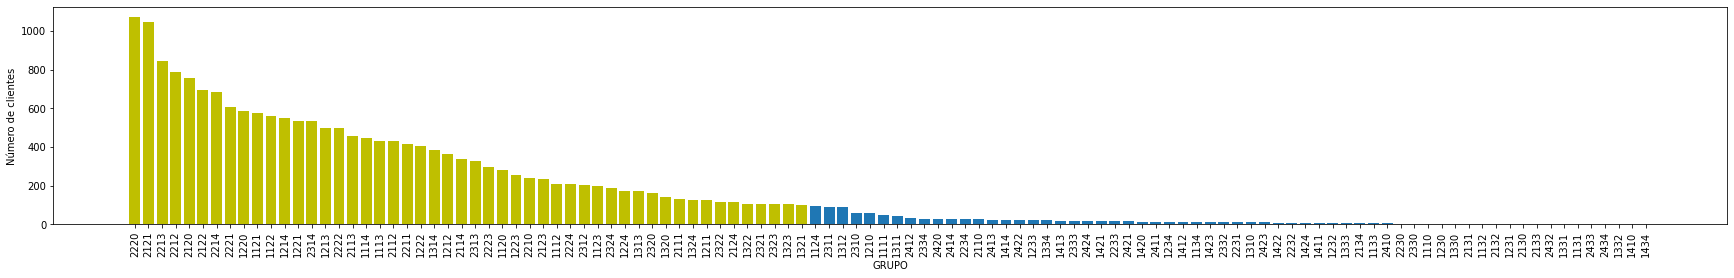

50 grupos tienen mas de 100 clientes


In [ ]:
#############
# YOUR CODE #
#############
threshold = 100
plt.figure(figsize = (30,4))
print(train_df['GRUPO'].value_counts())
bars =train_df['GRUPO'].apply(str).value_counts()
bars  = plt.bar(bars.index, bars.values)
plt.xticks(rotation = 90)
[bar.set_fc('y') for bar in bars if bar.get_height() > threshold]
plt.xlabel('GRUPO')
plt.ylabel('Número de clientes')
plt.show()
df_grupos = pd.DataFrame(train_df['GRUPO'].value_counts())
print("{0} grupos tienen mas de {1} clientes".format(df_grupos[df_grupos.GRUPO > threshold].shape[0], threshold))
#######
# END #
#######

In [ ]:
class bin_counter(object):
    def __init__(self, back_off_threshold = 0):
        self.back_off_threshold = back_off_threshold
        self.backed_off_categories = []
        pass
    def fit_transform(self, x, y):
        self.fit(x,y)
        return self.transform(x)
    def transform(self, x):
        N = len(x)
        output = np.empty((N, self.d))
        x_categories = np.unique(x)
        for cat in x_categories:
            if cat not in self.code_book:
                code = self.code_book['average']
            elif cat in self.backed_off_categories:
                code = self.code_book['back-off']
            else:
                code = self.code_book[cat]
            posi = np.where(x==cat)[0]
            output[posi,:] = code
        return output
    def fit(self, x, y):
        self.code_book = {}
        N = len(x)
        y_categories = np.unique(y)
        self.d = len(y_categories)
        x_categories = np.unique(x)
        num_x_categories = len(x_categories)
        y_ohe = OneHotEncoder(sparse=False).fit_transform(y.reshape(-1,1))
        back_off_counts = np.zeros(self.d)
        num_back_off = 0
        for cat in x_categories:
            posi = np.where(x==cat)[0]
            if len(posi) >= self.back_off_threshold:
                code = np.mean(y_ohe[posi,:],0)
                self.code_book[cat] = code
            else:
                self.backed_off_categories.append(cat)
                back_off_counts += np.sum(y_ohe[posi,:],0)
                num_back_off += len(posi)
        if num_back_off > 0:
            self.code_book['back-off']  = back_off_counts / num_back_off
        self.code_book['average'] =  np.mean(y_ohe,0)

Para evaluar el efecto del *leakage* vamos a en primer lugar usar el conjunto de entrenamiento que hemos empleado hasta ahora para aprender los conteos de bin y el modelo de regresión logística. Complete la parte final de este código para entrenar el modelo y medir sus prestaciones

{'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs', 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)} 
 ____________________________________________________________________________________________________
Score with the training data 0.8134
Score with the test data 0.8098 
 ____________________________________________________________________________________________________
{'Baseline': 0.7773, 'LogisticRegression': 0.7818, 'LOG_LogisticRegression': 0.7876, 'POL_2_LOG_LogisticRegression': 0.7886, 'AGE_dummies_LOG_LogisticRegression': 0.7886, 'More_CAT_dummies_LOG_LogisticRegression': 0.811, 'More_CAT_dummies_LOG_RandomForest': 0.8082, 'Demografical_var_LogisticRegression': 0.8111, 'BC_Leakage_LogisticRegression': 0.8098} 
 ____________________________________________________________________________________________________


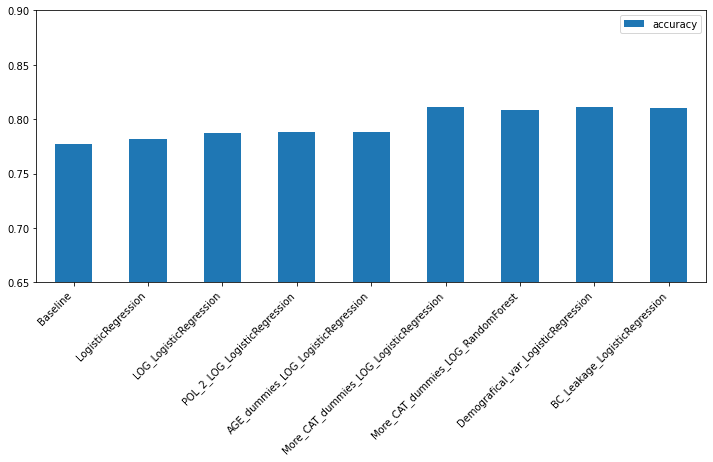


 ____________________________________________________________________________________________________
AUC is the percentage of the ROC plot that is underneath the curve: 0.7613851580842724


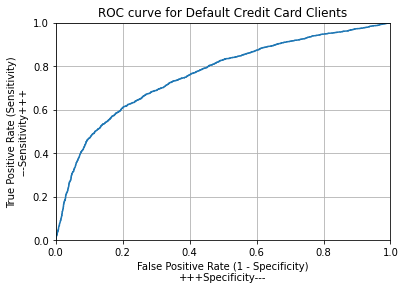

_____________________________________________________________________________________________________ 
Variable que más peso tiene (valor absoluto) ('PAY_0_dis1', 0.7077034979100961)
2º Variable que más peso tiene (valor absoluto) ('PAY_2_dis1', 0.47528221311235835)
3º Variable que más peso tiene (valor absoluto) ('PAY_0_dis2', 0.257837282034798)
_____________________________________________________________________________________________________


[('PAY_0_dis1', 0.7077034979100961),
 ('PAY_2_dis1', 0.47528221311235835),
 ('PAY_0_dis2', 0.257837282034798),
 ('LIMIT_BAL', 0.20530639913103255),
 ('PAY_3_dis2', 0.1839606863253515),
 ('GRUPO_BC', 0.18313263459819756),
 ('PAY_AMT2', 0.1757684792675121),
 ('PAY_3_dis1', 0.15140813599273736),
 ('PAY_AMT3', 0.15088270673559803),
 ('PAY_2_dis2', 0.1504573552223904),
 ('BILL_AMT3', 0.13140968356126528),
 ('EDUCATION2', 0.12358037201252127),
 ('PAY_5_dis2', 0.1222437374608856),
 ('BILL_AMT2', 0.12144626653780052),
 ('AGE_bin_3', 0.11750861427287772),
 ('PAY_6_dis2', 0.11617382571501315),
 ('PAY_0_dis0', 0.11543856422289635),
 ('AGE_bin_2', 0.11406844100504697),
 ('AGE_bin_4', 0.0988126871270157),
 ('BILL_AMT1', 0.09578793642047574),
 ('PAY_5_dis1', 0.09417599068833168),
 ('BILL_AMT5', 0.09219164505483213),
 ('PAY_2_dis0', 0.0907113638482576),
 ('EDUCATION1', 0.08391324293217202),
 ('AGE_bin_1', 0.08389761066004656),
 ('EDUCATION0', 0.07896888174006084),
 ('BILL_AMT6', 0.0687873689180751),


In [ ]:
bc_leakage = bin_counter(back_off_threshold=100)
train_grupo_bc = bc_leakage.fit_transform(train_df['GRUPO'].values, Y_train)
test_grupo_bc = bc_leakage.transform(test_df['GRUPO'].values)

"""
- Codifica dummy encoding las variables PAY_0_dis', 'PAY_2_dis',
       'PAY_3_dis', 'PAY_4_dis', 'PAY_5_dis', 'PAY_6_dis'
- genera X_train_e  apilando las columnas de LXtrain, X_train_cat_dummy y train_df_bc[:,1]
- genera X_test_e análogamente
- entrena el modelo de regresión logística con X_train_e
- evalúa el modelo (acierto en entrenamiento, acierto en test y area bajo la curva ROC)
"""
#############
# YOUR CODE #
#############
X_train_e = LXtrain.copy()
X_test_e = LXtest.copy()

cat_vars = ['PAY_0_dis', 'PAY_2_dis', 'PAY_3_dis', 'PAY_4_dis', 'PAY_5_dis', 'PAY_6_dis']
for col in cat_vars:
    create_dummy(col,train_df,test_df,X_train_e,X_test_e)
X_train_e['GRUPO_BC'] = train_grupo_bc[:,1]
X_test_e['GRUPO_BC'] = test_grupo_bc[:,1]


# GridSearch
grid_pipe = GridSearchCV(pipe, param_grid= params_pipe, cv=5)
grid_pipe.fit(X_train_e, Y_train)

# Storing the result
global_results['BC_Leakage_LogisticRegression'] = grid_pipe.score(X_test_e,Y_test)

# Print result
printReport(grid_pipe, X_train_e, Y_train, X_test_e, Y_test, global_results)

#######
# END #
#######

Ahora repetid el análisis de la celda anterior pero previamente dividiendo el conjunto de entrenamiento en dos mitades del mismo tamaño: 
- `train_bc_df` para aprender los conteos de bin y 
- `train_model_df` para entrenar el regresor logístico

Comparad las prestaciones en ambos casos y evaluar el impacto del *leakage*

{'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs', 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)} 
 ____________________________________________________________________________________________________
Score with the training data 0.8130
Score with the test data 0.8121 
 ____________________________________________________________________________________________________
{'Baseline': 0.7773, 'LogisticRegression': 0.7818, 'LOG_LogisticRegression': 0.7876, 'POL_2_LOG_LogisticRegression': 0.7886, 'AGE_dummies_LOG_LogisticRegression': 0.7886, 'More_CAT_dummies_LOG_LogisticRegression': 0.811, 'More_CAT_dummies_LOG_RandomForest': 0.8082, 'Demografical_var_LogisticRegression': 0.8111, 'BC_Leakage_LogisticRegression': 0.8098, 'BC_Leakage_2_Trains_LogisticRegression': 0.8121} 
 ____________________________________________________________________________________________________


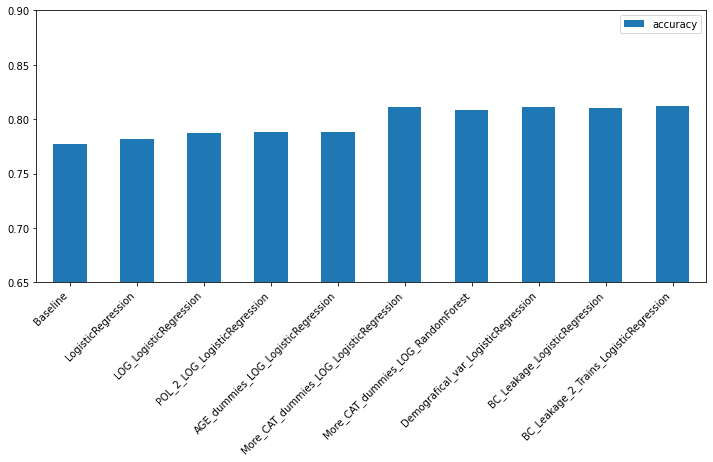


 ____________________________________________________________________________________________________
AUC is the percentage of the ROC plot that is underneath the curve: 0.7618562324973814


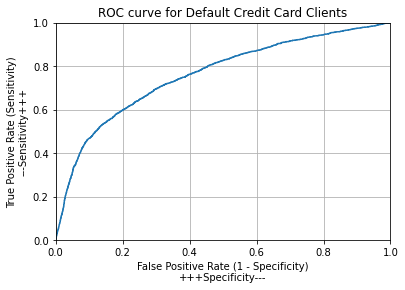

_____________________________________________________________________________________________________ 
Variable que más peso tiene (valor absoluto) ('PAY_0_dis1', 0.8147516706414814)
2º Variable que más peso tiene (valor absoluto) ('PAY_2_dis1', 0.6529594124968158)
3º Variable que más peso tiene (valor absoluto) ('PAY_5_dis1', 0.2854840716081839)
_____________________________________________________________________________________________________


[('PAY_0_dis1', 0.8147516706414814),
 ('PAY_2_dis1', 0.6529594124968158),
 ('PAY_5_dis1', 0.2854840716081839),
 ('PAY_5_dis2', 0.2287627972765277),
 ('PAY_2_dis2', 0.21852456074215984),
 ('PAY_0_dis2', 0.21055311682600455),
 ('PAY_2_dis0', 0.19807836015363933),
 ('PAY_0_dis0', 0.19464912416353722),
 ('LIMIT_BAL', 0.19175083744162325),
 ('PAY_AMT3', 0.18223744839537084),
 ('PAY_3_dis2', 0.16716088818548028),
 ('PAY_5_dis0', 0.1663628718459638),
 ('BILL_AMT2', 0.16383815698222534),
 ('BILL_AMT3', 0.16116869033024375),
 ('PAY_AMT2', 0.14942730258639428),
 ('PAY_4_dis1', 0.14720259975013938),
 ('EDUCATION2', 0.14385055634383384),
 ('PAY_6_dis2', 0.12321530513686493),
 ('BILL_AMT1', 0.11841134719873726),
 ('PAY_3_dis1', 0.1080718738134465),
 ('PAY_AMT1', 0.0880697269100548),
 ('MARRIAGE0', 0.08673126301917991),
 ('PAY_AMT4', 0.07645802643136816),
 ('BILL_AMT6', 0.05860048756310662),
 ('AGE_bin_2', 0.043969152753932844),
 ('PAY_AMT5', 0.04156878283332666),
 ('PAY_AMT6', 0.03936293388523059),

In [ ]:
#############
# YOUR CODE #
#############
from sklearn.model_selection import train_test_split
train_bc_df , train_model_df  = train_test_split(train_df, test_size=0.5, random_state=1)
 

bc_leakage = bin_counter(back_off_threshold=100)
# Subconjunto de conjunto de entrenamiento para aprender los bins.
train_grupo_bc       = bc_leakage.fit_transform(train_bc_df['GRUPO'].values, Y_train)

train_grupo_bc_model = bc_leakage.transform(train_model_df['GRUPO'].values)
test_grupo_bc        = bc_leakage.transform(test_df['GRUPO'].values)


# Training set observations
X_train_e_noleak = LXtrain.copy()
X_train_e_noleak = X_train_e_noleak.loc[train_model_df.index,:]
Y_train_e_noleak = train_model_df['default payment next month'].copy()
X_test_e_noleak = LXtest.copy()

cat_vars = ['PAY_0_dis', 'PAY_2_dis', 'PAY_3_dis', 'PAY_4_dis', 'PAY_5_dis', 'PAY_6_dis']
for col in cat_vars:
    create_dummy(col,train_model_df,test_df,X_train_e_noleak,X_test_e_noleak)
    
X_train_e_noleak['GRUPO_BC'] = train_grupo_bc_model[:,1]
X_test_e_noleak['GRUPO_BC'] = test_grupo_bc[:,1]


# GridSearch
grid_pipe_noleak = GridSearchCV(pipe, param_grid= params_pipe, cv=5)
grid_pipe_noleak.fit(X_train_e_noleak, Y_train_e_noleak)

# Storing the result
global_results['BC_Leakage_2_Trains_LogisticRegression'] = grid_pipe_noleak.score(X_test_e_noleak,Y_test)

# Print result
printReport(grid_pipe_noleak, X_train_e_noleak, Y_train_e_noleak, X_test_e_noleak, Y_test, global_results)

#######
# END #
#######

### ¿Cuál es el peso de la variable `GRUPO` codificada con conteo de bin en ambos casos?


In [ ]:
#############
# YOUR CODE #
#############
pesos = getWeights(grid_pipe.best_estimator_.named_steps['logistic'], X_train_e.columns)
len(pesos)
for i in range(len(pesos)):
  if pesos[i][0] == 'GRUPO_BC':
    print("El peso de la variable global en el entrenamiento con leakeage es: {0:.4f}".format(pesos[i][1]))

pesos = getWeights(grid_pipe_noleak.best_estimator_.named_steps['logistic'], X_train_e_noleak.columns)
len(pesos)
for i in range(len(pesos)):
  if pesos[i][0] == 'GRUPO_BC':
    print("El peso de la variable global en el entrenamiento sin leakeage es: {0:.4f}".format(pesos[i][1]))
#######
# END #
#######

El peso de la variable global en el entrenamiento con leakeage es: 0.1831
El peso de la variable global en el entrenamiento sin leakeage es: 0.0377


## OPCIONAL: interpretabilidad de los grupos demográficos (5%, extra)

**Este apartado es opcional: su nota se suma a la nota del proyecto, pero no es necesario para conseguir la máxima calificación.**

Ordenad los grupos de acuerdo a la probabilidad de default y verificar si hay muchas diferencias entre las primeras posiciones del *ranking*, las últimas, y los valores *bask-off* y *average*.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


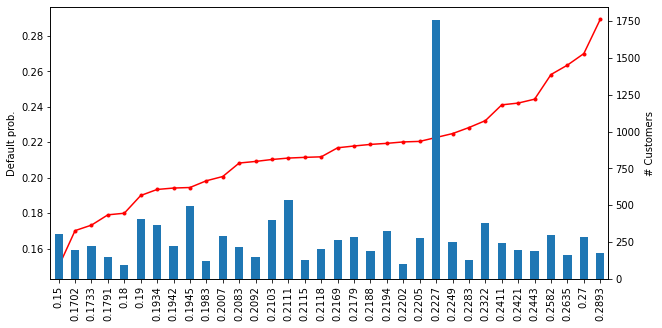

In [ ]:
#############
# YOUR CODE #
#############
train_model_df['GRUPO_BC'] = X_train_e_noleak['GRUPO_BC']

df_orden = pd.DataFrame(train_model_df.groupby(['GRUPO_BC'])['GRUPO_BC'].agg(['count']).sort_values(by='GRUPO_BC').reset_index())
df_orden['GRUPO_BC_4d'] = df_orden['GRUPO_BC'].apply(lambda x: float("{:.4f}".format(x)))

ax = df_orden['GRUPO_BC_4d'].plot(label="PD", style='.-', color='r',figsize=(10,5), ylabel="Default prob.")
df_orden['count'].plot(secondary_y=True, label="Nº", kind='bar').set_ylabel("# Customers")
ax = ax.set_xticklabels(df_orden["GRUPO_BC_4d"])
#######
# END #
#######

# ALTERNATIVA simple a 1º Apartado:

- Creamos una variable continua PAY_X_continua con los meses impagados a partir de las variables PAY_X, imputando a 0 los valores que eran negativos

- Con esta alternativa simple y solo con variables numéricas nos acercamos rapidamente a un accuracy alto y un AUC aceptable

- La variable más relevante de este modelo es la cantidad de meses impagados PAY_0_continua

In [ ]:
'''df = pd.read_excel(data_sheet,
                  header=1,
                  skiprows=0,
                  index_col=0)

for i in df.columns[5:11]:
    df[i+'_continua'] = df[i].apply(lambda x: 0 if x in [-2,-1,0] else x)
    df[i+'_dis'] = df[i].apply(lambda x: 1 if x>0 else x)

# Train Test
train_df, test_df = train_test_split(df, test_size=10000, random_state=42)

# Regex to get Numeric Varibles
r = re.compile("^PAY_[0-9]$|^PAY_[0-9]_dis$|^SEX$|^EDUCATION$|^MARRIAGE$|^defa*") # REGEX EXPRESSION
num_var = [col for col in df.columns if  col not in list(filter(r.match, df.columns))]
print(num_var)

# Training set observations
X_train = train_df[num_var]
# Training set targets
Y_train = train_df['default payment next month'].values
# Test set observations
X_test = test_df[num_var]
# Test set targets
Y_test = test_df['default payment next month'].values

# GridSearch
params_pipe = {'logistic__solver':['lbfgs'],
               'logistic__max_iter':[10000],
               'logistic__penalty' : ['l2'],
               'scaler':[MinMaxScaler(), StandardScaler(),'passthrough']}

# Set the Pipeline
pipe = Pipeline(steps=[('scaler', MinMaxScaler()), ('logistic',LogisticRegression())])

grid_pipe = GridSearchCV(pipe, param_grid= params_pipe, cv=5)
grid_pipe.fit(X_train, Y_train)
print(grid_pipe.best_params_,'\n','_'*100)
print("Score with the training data {0:.4f}".format(grid_pipe.score(X_train, Y_train)))
print("Score with the test data {0:.4f}".format(grid_pipe.score(X_test,Y_test)),'\n','_'*100)

# Storing the result
global_results['ALT_LogisticRegression'] = grid_pipe.score(X_test,Y_test)
print(global_results,'\n','_'*100)

# ROC AUC
roc(X_test, Y_test, grid_pipe)

# Weights
scaler = grid_pipe.best_estimator_.named_steps['scaler']
logreg = grid_pipe.best_estimator_.named_steps['logistic']
weights = []
weights_abs = []
for var,coef in zip(num_var,logreg.coef_[0]):
    weights_abs.append((var,abs(coef)))
    weights.append((var,coef))
    weights_abs.sort(key=lambda tup: tup[1],reverse=True)

weights_abs

print('_'*101,'\n''Variable que más peso tiene (valor absoluto)',weights_abs[0])
print('2º Variable que más peso tiene (valor absoluto)',weights_abs[1])
print('3º Variable que más peso tiene (valor absoluto)',weights_abs[2])'''

'df = pd.read_excel(data_sheet,\n                  header=1,\n                  skiprows=0,\n                  index_col=0)\n\nfor i in df.columns[5:11]:\n    df[i+\'_continua\'] = df[i].apply(lambda x: 0 if x in [-2,-1,0] else x)\n    df[i+\'_dis\'] = df[i].apply(lambda x: 1 if x>0 else x)\n\n# Train Test\ntrain_df, test_df = train_test_split(df, test_size=10000, random_state=42)\n\n# Regex to get Numeric Varibles\nr = re.compile("^PAY_[0-9]$|^PAY_[0-9]_dis$|^SEX$|^EDUCATION$|^MARRIAGE$|^defa*") # REGEX EXPRESSION\nnum_var = [col for col in df.columns if  col not in list(filter(r.match, df.columns))]\nprint(num_var)\n\n# Training set observations\nX_train = train_df[num_var]\n# Training set targets\nY_train = train_df[\'default payment next month\'].values\n# Test set observations\nX_test = test_df[num_var]\n# Test set targets\nY_test = test_df[\'default payment next month\'].values\n\n# GridSearch\nparams_pipe = {\'logistic__solver\':[\'lbfgs\'],\n               \'logistic__max_iter\